# Spectroscopic factors

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ November 1, 2022

This notebook serves as a testbed for calculating spectroscopic factors using mean field approximations for initial and final states and applying SRG transformations to the operator. The normalization of spectroscopic overlaps give relative spectroscopic factors. The first step is to compute the overlap of $^4\rm{He}$ with $^3\rm{H}$ and compare to [VMC calculations](https://www.phy.anl.gov/theory/research/overlaps/).

_Last update:_ December 1, 2022

__To-do list:__
* Check if you need the $(-i)^l$ factor in the Hankel transformation function. The factor may cancel out in all relevant formulas (like the overlap wave function). Test that your answer does not change for $l=0$ but does for $l>0$.
* Sanity check by integrating over $k$, $k'$, and $K$ instead.
* Think about structure, write scripts, and update this notebook.

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg as la
from scipy.interpolate import interp1d, RectBivariateSpline
from scipy.special import spherical_jn, sph_harm
import shutil
from sympy.physics.quantum.cg import CG
import vegas

In [2]:
# Imports from scripts
from scripts.figures import set_rc_parameters, label_nlj_state, label_nucleus
from scripts.integration import (
    gaussian_quadrature_mesh, momentum_mesh, unattach_weights_from_matrix
)
from scripts.potentials import Potential
from scripts.srg import get_transformation
from scripts.tools import coupled_channel
from scripts.woodsaxon import ws

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
# Save figures in the following directory
figures_directory = '../figures/spectroscopic_factors/'

## Classes

_Move some of these into scripts at a later date._

In [5]:
class SingleParticleBasis:
    """
    Single-particle basis class. Handles the wave functions associated with the
    Wood-Saxon potential from the subroutine in woodsaxon.f90. Generates wave
    functions in coordinate and momentum space.
    
    Parameters
    ----------
    nucleus_name : str
        Name of the nucleus (e.g., 'O16', 'Ca40', etc.)
    Z : int
        Proton number of the nucleus.
    N : int
        Neutron number of the nucleus.
    n_max : int
        Maximum principal quantum number where n = 1, 2, ..., n_max.
    l_max : int
        Maximum orbital angular momentum where l = 0, 1, ..., l_max.
    rmax : float, optional
        Maximum r for orbital tables.
    ntab : int, optional
        Number of points for orbital tables.
        
    """
    
    
    def __init__(self, nucleus_name, Z, N, n_max, l_max, rmax=40, ntab=2000):

        # Generate orbitals
        self.run_wood_saxon_code(nucleus_name, Z, N, n_max, l_max, rmax, ntab)
                
        # Order single-particle states with lowest energy first
        self.order_sp_states()
        
        # Move output files to relevant directory
        wood_saxon_directory = f"../data/wood_saxon/{nucleus_name}/"
        shutil.move("ws_log", wood_saxon_directory + "ws_log")
        shutil.move("ws_pot", wood_saxon_directory + "ws_pot")
        shutil.move("ws_rho", wood_saxon_directory + "ws_rho")
        
        # Move proton orbital files
        for sp_state in self.sp_states['proton']:
            n, l, j, _ = sp_state
            file_name = f"p.n{int(n-1)}.l{l}.j{int(2*j)}.orb"
            shutil.move(file_name, wood_saxon_directory + file_name)
            
        # Move neutron orbital files
        for sp_state in self.sp_states['neutron']:
            n, l, j, _ = sp_state
            file_name = f"n.n{int(n-1)}.l{l}.j{int(2*j)}.orb"
            shutil.move(file_name, wood_saxon_directory + file_name)
            
        # Organize wave functions in dictionary with s.p. state as key
        self.sp_wfs = {}
        
        # Do proton orbitals first
        for sp_state in self.sp_states['proton']:
            n, l, j, tau = sp_state
            file_name = f"p.n{int(n-1)}.l{l}.j{int(2*j)}.orb"
            data = np.loadtxt(wood_saxon_directory + file_name)
            self.sp_wfs[(n,l,j,tau)] = data[:, 1]
        
        # Neutron orbitals
        for sp_state in self.sp_states['neutron']:
            n, l, j, tau = sp_state
            file_name = f"n.n{int(n-1)}.l{l}.j{int(2*j)}.orb"
            data = np.loadtxt(wood_saxon_directory + file_name)
            self.sp_wfs[(n,l,j,tau)] = data[:, 1]

            
    def run_wood_saxon_code(
            self, nucleus_name, Z, N, n_max, l_max, rmax, ntab):
        """Run Wood-Saxon code to generate data."""
        
        # Total number of nucleons
        A = Z + N
        
        # Type of orbitals: 1 - nucleons with no Coulomb
        #                   2 - distinguish protons and neutrons
        ntau = 2
        
        # Orbitals to consider (note, we track 2*j not j)
        norb, lorb, jorb = [], [], []
        for n in range(1, n_max+1):
            for l in range(0, l_max+1):
                norb.append(n)
                lorb.append(l)
                jorb.append(int(2*(l+1/2)))
                if int(2*(l-1/2)) > 0:  # Don't append negative j
                    norb.append(n)
                    lorb.append(l)
                    jorb.append(int(2*(l-1/2)))
        nrad = len(jorb)
        orbws = np.zeros(shape=(2,nrad,ntab), order='F')
    
        # Divide orbital by r? -> get R(r); false: get u(r)=r R(r)
        rdiv = False
        dens = True
    
        # Set parameters of the Wood-Saxon potential
        prm = np.zeros(shape=(2,9), order='F')
    
        # Starting with vws (p & n)
        if nucleus_name == 'He4':
            # prm[:,0] = 76.8412
            prm[:,0] = 90.0  # For bound 1p_{1/2} state
        elif nucleus_name == 'O16':
            prm[:,0] = 58.0611
        elif nucleus_name == 'Ca40':
            prm[:,0] = 54.3051
        elif nucleus_name == 'Ca48':
            prm[0,0] = 59.4522
            prm[1,0] = 46.9322
    
        # Not sure about these (better way to load these parameters?)
        prm[:,1] = 1.275
        prm[:,2] = 0.7
        prm[:,3] = 0.
        prm[:,4] = 1.
        prm[:,5] = 36
        prm[:,6] = 1.32
        prm[:,7] = 0.7
        prm[:,8] = 1.275
        
        # Print summary, potentials, and densities
        prnt = True
        prntorb = True

        # Run Fortran subroutine
        ws(ntau, A, Z, rmax, orbws, norb, lorb, jorb, prm, rdiv, prnt, prntorb,
           dens)

        # Set radial distance array and step-size as instance attributes
        self.dr = rmax / ntab
        self.r_array = np.arange(self.dr, rmax + self.dr, self.dr)
        
        
    def order_sp_states(self):
        """Keep track of all s.p. states and occupied s.p. states"""

        self.sp_states = {'proton': [], 'neutron': []}
        self.occ_states = {'proton': [], 'neutron': []}
        proton_count = 0
        neutron_count = 0
    
        # Order single-particle states using the ws_log file
        with open('ws_log', 'r') as f:
            for line in f:
                unit = line.strip().split()
                
                # Protons
                if len(unit) > 0 and unit[0] == '1':
                    self.sp_states['proton'].append(
                        (int(unit[1])+1, int(unit[2]), int(unit[3])/2, 1/2)
                    )
                    if proton_count < Z:
                        self.occ_states['proton'].append(
                            (int(unit[1])+1, int(unit[2]), int(unit[3])/2, 1/2)
                        )
                        # Add up filled proton states
                        proton_count += int(unit[5])
                
                # Neutrons
                elif len(unit) > 0 and unit[0] == '2':
                    self.sp_states['neutron'].append(
                        (int(unit[1])+1, int(unit[2]), int(unit[3])/2, -1/2)
                    )
                    if neutron_count < N:
                        self.occ_states['neutron'].append(
                            (int(unit[1])+1, int(unit[2]), int(unit[3])/2, -1/2)
                        )
                        # Add up filled proton states
                        neutron_count += int(unit[5])
                        
    
    def get_wf_rspace(self, n, l, j, tau, print_normalization=False):
        """Single-particle wave function in coordinate space."""
        
        u_array = self.sp_wfs[(n, l, j, tau)]

        # Normalization: \int dr |u(r)|^2 = 1
        if print_normalization:
            normalization = np.sum(self.dr*u_array**2)
            print(f"Coordinate space normalization = {normalization}.")

        return self.r_array, u_array
    
    
    def fourier_transformation(self, l, k_array):
        """Fourier transformation matrix for given orbital angular momentum."""
        
        # r_array column vectors and k_array row vectors where both grids are
        # n x m matrices
        r_cols, k_rows = np.meshgrid(self.r_array, k_array)
        
        # Transformation matrix with shape n x m, where m is the length of
        # r_array and n is the length of the k_array
        # M = np.sqrt(2/np.pi) * self.dr * r_cols * spherical_jn(l, k_rows*r_cols)
        ### TESTING
        M = 1j**(-l) * np.sqrt(2/np.pi) * self.dr * r_cols * spherical_jn(
            l, k_rows*r_cols
        )
        
        return M
    
    
    def get_wf_kspace(
            self, n, l, j, tau, print_normalization=False, interpolate=False,
            kmax=15.0, kmid=3.0, ntot=120):
        """Single-particle wave function in momentum space."""
    
        # Set momentum mesh with more points at low momentum
        k_array, k_weights = momentum_mesh(kmax, kmid, ntot)
    
        # Get coordinate-space s.p. wave function
        _, u_array = self.get_wf_rspace(n, l, j, tau)

        # Fourier-transform the wave function to momentum space
        phi_array = self.fourier_transformation(l, k_array) @ u_array
    
        # Normalization: \int dk k^2 |\phi(k)|^2 = 1
        if print_normalization:
            normalization = np.sum(k_weights*k_array**2*phi_array**2)
            print(f"Momentum space normalization = {normalization}.")
            
        # Interpolate and return function?
        if interpolate:
            phi_func = interp1d(k_array, phi_array, kind='linear',
                                bounds_error=False, fill_value='extrapolate')
            return phi_func
        
        # Otherwise return momentum, weights, and \phi(k)
        else:
            return k_array, k_weights, phi_array

In [6]:
class DeltaUDagger(SingleParticleBasis):
    """
    Matrix elements of \delta U^\dagger in the s.p. basis.
    
    Parameters
    ----------
    nucleus_name : str
        Name of the nucleus (e.g., 'O16', 'Ca40', etc.)
    Z : int
        Proton number of the nucleus.
    N : int
        Neutron number of the nucleus.
    n_max : int
        Maximum principal quantum number where n = 1, 2, ..., n_max.
    l_max : int
        Maximum orbital angular momentum where l = 0, 1, ..., l_max.
    channels : tuple
        Partial wave channels to include in the calculation.
    kvnn : int
        This number specifies the potential.
    rmax : float, optional
        Maximum r for orbital tables.
    ntab : int, optional
        Number of points for orbital tables.
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1] of the potential.
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1] of the potential.
    ntot : int, optional
        Number of momentum points in mesh of the potential.
    generator : str, optional
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float, optional
        SRG evolution parameter \lambda [fm^-1].
    
    """
    
    
    def __init__(
            self, nucleus_name, Z, N, n_max, l_max, channels, kvnn, rmax=40,
            ntab=2000, kmax=15.0, kmid=3.0, ntot=120, generator='Wegner',
            lamb=1.35):
        
        # Call SingleParticleBasis class given the specifications
        super().__init__(nucleus_name, Z, N, n_max, l_max, rmax, ntab)
        
        # Set instance attributes
        self.channels = channels
        self.kvnn = kvnn
        self.kmax = kmax
        self.kmid = kmid
        self.ntot = ntot
        self.generator = generator
        self.lamb = lamb
        
        # Precalculate Clebsch-Gordan table with j_max = 4
        self.cg_table = self.set_clebsch_gordan_table(4)
        
        # Spin projections
        self.spins = np.array([1/2, -1/2])

        # Set interpolating functions for s.p. wave functions \phi
        self.phi_functions = {}
        for key in self.sp_wfs:
            n, l, j, tau = key
            self.phi_functions[(n,l,j,tau)] = self.get_wf_kspace(
                n, l, j, tau, interpolate=True
            )

        # Set interpolating functions for \delta U^\dagger
        self.delta_U_dagger_functions = {}
        for channel in channels:
            self.delta_U_dagger_functions[channel] = (
                self.interpolate_delta_U_dagger(channel)
            )
    
    
    def set_clebsch_gordan_table(self, j_max):
        """
        Calculate Clebsch-Gordan coefficients for all combinations of j and m_j
        up to j_max.
    
        Parameters
        ----------
        j_max : int
            Maximum j value for j_1, j_2, and j_3. This also constrains m_j.
    
        Returns
        -------
        cg_table : dict
            Table of Clebsch-Gordan coefficients <j_1 m_j_1 j_2 m_j_2|j_3 m_j_3>
            for each combination of angular momenta.
        
        """
        
        cg_table = {}
        
        j_array = np.arange(0, j_max+1/2, 1/2)

        for j_1 in j_array:
            for m_1 in np.arange(-j_1, j_1+1, 1):
                for j_2 in j_array:
                    for m_2 in np.arange(-j_2, j_2+1, 1):
                        for j_3 in j_array:
                            for m_3 in np.arange(-j_3, j_3+1, 1):
                                cg_table[(j_1,m_1,j_2,m_2,j_3,m_3)] = float(
                                    CG(j_1,m_1,j_2,m_2,j_3,m_3).doit()
                                )
                                
        return cg_table

    
    def get_channel_str(self, Lp, L, S, J):
        """Gets the partial wave channel string given quantum numbers."""
    
        # Total orbital angular momentum L' = 0, 1, 2, ...
        if Lp == 0:
            Lp_str = 'S'
        elif Lp == 1:
            Lp_str = 'P'
        elif Lp == 2:
            Lp_str = 'D'
        elif Lp == 3:
            Lp_str = 'F'
        elif Lp == 4:
            Lp_str = 'G'
        elif Lp == 5:
            Lp_str = 'H'
        else:
            raise RuntimeError("Channel L' exceeds the range of the function.")
        
        channel = f"{2*S+1}{Lp_str}{J}"
    
        # Total orbital angular momentum L = 0, 1, 2, ...
        # L = L' if the channel is not coupled
        if channel in ['3S1', '3D1', '3P2', '3F2', '3D3', '3G3']:
        
            if L == 0:
                L_str = 'S'
            elif L == 1:
                L_str = 'P'
            elif L == 2:
                L_str = 'D'
            elif L == 3:
                L_str = 'F'
            elif L == 4:
                L_str = 'G'
            elif L == 5:
                L_str = 'H'
            else:
                raise RuntimeError(
                    "Channel L exceeds the range of the function."
                )
            
            channel += f"-{2*S+1}{L_str}{J}"

        return channel
    
    
    def get_channel_quantum_numbers(self, channel):
        """Gets the quantum numbers of a partial wave channel."""
    
        # Total orbital angular momentum L' = 0, 1, 2, ...
        if channel[1] == 'S':
            Lp = 0
        elif channel[1] == 'P':
            Lp = 1
        elif channel[1] == 'D':
            Lp = 2
        elif channel[1] == 'F':
            Lp = 3
        elif channel[1] == 'G':
            Lp = 4
        elif channel[1] == 'H':
            Lp = 5
        else:
            raise RuntimeError("Channel L' exceeds the range of the function.")
    
        # Total orbital angular momentum L = 0, 1, 2, ...
        if coupled_channel(channel[:3]):
        
            if channel[5] == 'S':
                L = 0
            elif channel[5] == 'P':
                L = 1
            elif channel[5] == 'D':
                L = 2
            elif channel[5] == 'F':
                L = 3
            elif channel[5] == 'G':
                L = 4
            elif channel[5] == 'H':
                L = 5
            else:
                raise RuntimeError(
                    "Channel L exceeds the range of the function."
                )
        
        # L = L' if the channel is not coupled
        else:
        
            L = Lp
        
        # Total spin S = 0 or 1
        S = int((int(channel[0])-1)/2)
    
        # Total angular momentum J = 0, 1, 2, ...
        J = int(channel[2])
            
        return Lp, L, S, J
    
    
    def get_total_isospin(self, L, S):
        """Total isospin according to antisymmetry."""
    
        # Make sure [1-(-1)^(L+S+T)] is not zero
        if (1-(-1)**(L+S)) == 0:
            T = 1
        else:
            T = 0
        
        return T
    
    
    def interpolate_delta_U_dagger(self, channel):
        """Interpolate \delta U^\dagger(k',k) for the given channel."""
    
        # Set channel argument to be compatible with potential functions
        if channel[:3] in ['3S1', '3D1']:
            channel_arg = '3S1'
        elif channel[:3] in ['3P2', '3F2']:
            channel_arg = '3P2'
        elif channel[:3] in ['3D3', '3G3']:
            channel_arg = '3D3'
        else:
            channel_arg = channel[:3]
        
        # Set potential
        potential = Potential(self.kvnn, channel_arg, self.kmax, self.kmid,
                              self.ntot)
    
        # Get momentum mesh
        k_array, k_weights = potential.load_mesh()
    
        # Initial and evolved Hamiltonians
        H_initial = potential.load_hamiltonian()
        if self.generator == 'Block-diag':
            H_evolved = potential.load_hamiltonian('srg', self.generator, 1.0,
                                                   lambda_bd=self.lamb)
        else:
            H_evolved = potential.load_hamiltonian('srg', self.generator,
                                                   self.lamb)
    
        # Get SRG transformation from Hamiltonians
        U_matrix_weights = get_transformation(H_initial, H_evolved)
    
        # Calculate \delta U^\dagger = (U - I)^\dagger
        I_matrix_weights = np.eye(len(U_matrix_weights), len(U_matrix_weights))
        delUdag_matrix_weights = (U_matrix_weights - I_matrix_weights).T

        # Get specific sub-block if coupled-channel
        n = self.ntot
        if channel in ['3S1-3D1', '3P2-3F2', '3D3-3G3']:
            delUdag_matrix = unattach_weights_from_matrix(
                k_array, k_weights, delUdag_matrix_weights[:n,n:2*n]
            )
        elif channel in ['3D1-3S1', '3F2-3P2', '3G3-3D3']:
            delUdag_matrix = unattach_weights_from_matrix(
                k_array, k_weights, delUdag_matrix_weights[n:2*n,:n]
            )
        elif channel in ['3D1-3D1', '3F2-3F2', '3G3-3G3']:
            delUdag_matrix = unattach_weights_from_matrix(
                k_array, k_weights, delUdag_matrix_weights[n:2*n,n:2*n]
            )
        else:
            delUdag_matrix = unattach_weights_from_matrix(
                k_array, k_weights, delUdag_matrix_weights[:n,:n]
            )
        
        # Interpolate \delta U^\dagger(k,k')
        delUdag_func = RectBivariateSpline(k_array, k_array, delUdag_matrix)
        ### TESTING
        # delUdag_func = RectBivariateSpline(k_array, k_array, delUdag_matrix, kx=1, ky=1)

        return delUdag_func
    

    def get_matrix_element(
            self, n_alpha, l_alpha, j_alpha, m_j_alpha, tau_alpha, n_beta,
            l_beta, j_beta, m_j_beta, tau_beta, n_gamma, l_gamma, j_gamma,
            m_j_gamma, tau_gamma, n_delta, l_delta, j_delta, m_j_delta,
            tau_delta):
        """
        Compute the specified matrix element of \delta U^\dagger.
        
        Parameters
        ----------
        n_* : int
            Principal quantum number n = 1, 2, 3, ...
        l_* : int
            Orbital angular momentum l = 0, 1, 2, ...
        j_* : float
            Total angular momentum j = 1/2, 3/2, 5/2, ...
        m_j_* : float
            Total angular momentum projection m_j = -j, -j+1, ..., j.
        tau_* : float
            Isospin projection \tau = +1/2 or -1/2.
        
        Returns
        -------
        delta_U_dagger : float
            Matrix element of \delta U^\dagger in the s.p. basis.
        
        """
        
        # Set attributes: combination of quantum numbers and \alpha, \beta, ...
        self.alpha = (n_alpha, l_alpha, j_alpha, m_j_alpha, tau_alpha)
        self.beta = (n_beta, l_beta, j_beta, m_j_beta, tau_beta)
        self.gamma = (n_gamma, l_gamma, j_gamma, m_j_gamma, tau_gamma)
        self.delta = (n_delta, l_delta, j_delta, m_j_delta, tau_delta)
        
        # Get all possible combinations of quantum numbers that give non-zero
        # contributions to the matrix element of \delta U^\dagger
        combinations = self.get_nonzero_combinations()
        # Note, there will still be some combinations that give zero because of
        # orthogonality of s.p. and relative spherical harmonics (e.g., all
        # s-waves for s.p. with a D-wave for relative)

        # Non-empty list
        if combinations:
        
            # Set-up integration with vegas up to k_max = 10 fm^-1
            k_limits = [0, 10]
            theta_limits = [0, np.pi]
            phi_limits = [0, 2*np.pi]
            integ = vegas.Integrator([k_limits, theta_limits, phi_limits,
                                      k_limits, theta_limits, phi_limits,
                                      k_limits, theta_limits, phi_limits])
        
            # Loop over quantum numbers
            delta_U_dagger = 0.0
            for quantum_numbers in combinations:
                
                # Set as instance attribute for integrand function
                self.quantum_numbers = quantum_numbers
                
                integrand_real = lambda x: self.integrand(x).real
                integrand_imag = lambda x: self.integrand(x).imag

                # Compute integrations over k1, k2, and k3 vectors
                # result = integ(self.integrand, nitn=10, neval=1e4)
                result_real = integ(integrand_real, nitn=10, neval=1e4)
                result_imag = integ(integrand_imag, nitn=10, neval=1e4)
                ### TESTING
                # result = integ(integrand, nitn=10, neval=1e3)
                # result = integ(integrand, nitn=20, neval=1e5)
                # result = integ(integrand, nitn=20, neval=1e3)
            
#                 ### TESTING
#                 print("Format is (n, l, j, m_j, \\tau):")
#                 print(self.alpha)
#                 print(self.beta)
#                 print(self.gamma)
#                 print(self.delta)
#                 print(result.summary())
#                 print(result)
                
                # delta_U_dagger += result.mean
                delta_U_dagger += result_real.mean + 1j*result_imag.mean
                
                ### TESTING
                # print(result_real)
                # print(result_imag)
                # delta_U_dagger += result_real.mean + 1j*result_imag.mean
            
        # Combination of s.p. states is zero
        else:
        
            delta_U_dagger = 0.0
        
        return delta_U_dagger
    
    
    def get_nonzero_combinations(self):
        """Returns all combinations of quantum numbers that give a non-zero
        product of Clebsch-Gordan coefficients in the calculation of the
        \delta U^\dagger matrix element.
        """
        
        # Unpack s.p. quantum numbers
        _, l_alpha, _, m_j_alpha, tau_alpha = self.alpha
        _, l_beta, _, m_j_beta, tau_beta = self.beta
        _, l_gamma, _, m_j_gamma, tau_gamma = self.gamma
        _, l_delta, _, m_j_delta, tau_delta = self.delta
        
        # Initialize list to store non-zero combinations of quantum numbers
        combinations = []
    
        # Set range of m_l values
        m_l_alphas = np.intersect1d(np.arange(-l_alpha, l_alpha+1, 1),
                                    m_j_alpha - self.spins)
        m_l_betas = np.intersect1d(np.arange(-l_beta, l_beta+1, 1),
                                   m_j_beta - self.spins)
        m_l_gammas = np.intersect1d(np.arange(-l_gamma, l_gamma+1, 1),
                                    m_j_gamma - self.spins)
        m_l_deltas = np.intersect1d(np.arange(-l_delta, l_delta+1, 1),
                                    m_j_delta - self.spins)
    
        # Loop over single-particle orbital angular momentum projections first
        for m_l_alpha in m_l_alphas:
        
            sigma_alpha = m_j_alpha - m_l_alpha
        
            for m_l_beta in m_l_betas:
            
                sigma_beta = m_j_beta - m_l_beta
            
                for m_l_gamma in m_l_gammas: 
                
                    sigma_gamma = m_j_gamma - m_l_gamma
                
                    for m_l_delta in m_l_deltas:
                    
                        sigma_delta = m_j_delta - m_l_delta

                        # Loop over channels
                        for channel in self.channels:
                        
                            # Determine channel quantum numbers
                            Lp, L, S, J = self.get_channel_quantum_numbers(
                                channel
                            )
                        
                            # Possible M_L' values
                            M_Lp_array = np.arange(-Lp, Lp+1, 1)
                        
                            # Possible M_L values
                            M_L_array = np.arange(-L, L+1, 1)
                        
                            # Possible M_S values
                            M_S_array = np.arange(-S, S+1, 1)
                        
                            # Possible M_J values
                            M_J_array = np.arange(-J, J+1, 1)
                
                            # Determine total isospin
                            T = self.get_total_isospin(L, S)
                        
                            # Possible M_T values
                            M_T_array = np.arange(-T, T+1, 1)
                        
                            for M_Lp in M_Lp_array:
                            
                                for M_L in M_L_array:
                                
                                    for M_S in M_S_array:
                                    
                                        # Spin CG's
                                        alpha_beta_spin_cg = self.cg_table[(
                                            1/2, sigma_alpha, 1/2, sigma_beta,
                                            S, M_S
                                        )]
                                        gamma_delta_spin_cg = self.cg_table[(
                                            1/2, sigma_gamma, 1/2, sigma_delta,
                                            S, M_S
                                        )]
                                    
                                        for M_J in M_J_array:
                                        
                                            # L-S coupling CG's
                                            Lp_S_J_cg = self.cg_table[(
                                                Lp, M_Lp, S, M_S, J, M_J
                                            )]
                                            L_S_J_cg = self.cg_table[(
                                                L, M_L, S, M_S, J, M_J
                                            )]
                                        
                                            for M_T in M_T_array:
                                            
                                                # Isopin CG's
                                                alpha_beta_isospin_cg = (
                                                    self.cg_table[(
                                                        1/2, tau_alpha, 1/2,
                                                        tau_beta, T, M_T
                                                    )]
                                                )
                                                gamma_delta_isospin_cg = (
                                                    self.cg_table[(
                                                        1/2, tau_gamma, 1/2,
                                                        tau_delta, T, M_T
                                                    )]
                                                )
                                            
                                                # Calculate product of CG's
                                                product = (
                                                    alpha_beta_spin_cg
                                                    * gamma_delta_spin_cg
                                                    * Lp_S_J_cg * L_S_J_cg
                                                    * alpha_beta_isospin_cg
                                                    * gamma_delta_isospin_cg
                                                )
                                            
                                                # Append combination if the
                                                # product is non-zero
                                                if product != 0:
                                                
                                                    quantum_numbers = {
                                                        'm_l_alpha': m_l_alpha,
                                                        'm_l_beta': m_l_beta,
                                                        'm_l_gamma': m_l_gamma,
                                                        'm_l_delta': m_l_delta,
                                                        'sigma_alpha': sigma_alpha,
                                                        'sigma_beta': sigma_beta,
                                                        'sigma_gamma': sigma_gamma,
                                                        'sigma_delta': sigma_delta,
                                                        'Lp': Lp, 'M_Lp': M_Lp,
                                                        'L': L, 'M_L': M_L,
                                                        'S': S, 'M_S': M_S,
                                                        'J': J, 'M_J': M_J,
                                                        'T': T, 'M_T': M_T                    
                                                    }
                                                
                                                    combinations.append(
                                                        quantum_numbers
                                                    )

        return combinations
    
    
    def integrand(self, momenta_array):
        """Integrand of the specified \delta U^\dagger matrix element."""
    
        # Unpack s.p. quantum numbers
        n_alpha, l_alpha, j_alpha, m_j_alpha, tau_alpha = self.alpha
        n_beta, l_beta, j_beta, m_j_beta, tau_beta = self.beta
        n_gamma, l_gamma, j_gamma, m_j_gamma, tau_gamma = self.gamma
        n_delta, l_delta, j_delta, m_j_delta, tau_delta = self.delta
        
        # Get particular combination of quantum numbers m_l, \sigma, L', etc.
        quantum_numbers = self.quantum_numbers
    
        # Get s.p. orbital angular momentum projections
        m_l_alpha = quantum_numbers['m_l_alpha']
        m_l_beta = quantum_numbers['m_l_beta']
        m_l_gamma = quantum_numbers['m_l_gamma']
        m_l_delta = quantum_numbers['m_l_delta']
    
        # Get s.p. spin projections
        sigma_alpha = quantum_numbers['sigma_alpha']
        sigma_beta = quantum_numbers['sigma_beta']
        sigma_gamma = quantum_numbers['sigma_gamma']
        sigma_delta = quantum_numbers['sigma_delta']
    
        # Get total orbital angular momentum and its projection
        Lp, M_Lp = quantum_numbers['Lp'], quantum_numbers['M_Lp']
        L, M_L = quantum_numbers['L'], quantum_numbers['M_L']
    
        # Get total spin and its projection
        S, M_S = quantum_numbers['S'], quantum_numbers['M_S']
    
        # Get total angular momentum and its projection
        J, M_J = quantum_numbers['J'], quantum_numbers['M_J']
    
        # Get total isospin and its projection
        T, M_T = quantum_numbers['T'], quantum_numbers['M_T']
    
        # Calculate s.p. l-s coupling Clebsch-Gordan coefficients
        alpha_cg = self.cg_table[(l_alpha, m_l_alpha, 1/2, sigma_alpha, j_alpha,
                                  m_j_alpha)]
        beta_cg = self.cg_table[(l_beta, m_l_beta, 1/2, sigma_beta, j_beta,
                                 m_j_beta)]
        gamma_cg = self.cg_table[(l_gamma, m_l_gamma, 1/2, sigma_gamma, j_gamma,
                                  m_j_gamma)]
        delta_cg = self.cg_table[(l_delta, m_l_delta, 1/2, sigma_delta, j_delta,
                                  m_j_delta)]
    
        # Calculate spin Clebsch-Gordan coefficients
        alpha_beta_spin_cg = self.cg_table[(1/2, sigma_alpha, 1/2, sigma_beta,
                                            S, M_S)]
        gamma_delta_spin_cg = self.cg_table[(1/2, sigma_gamma, 1/2, sigma_delta,
                                             S, M_S)]
    
        # Calculate isospin Clebsch-Gordan coefficients
        alpha_beta_isospin_cg = self.cg_table[(1/2, tau_alpha, 1/2, tau_beta, T,
                                               M_T)]
        gamma_delta_isospin_cg = self.cg_table[(1/2, tau_gamma, 1/2, tau_delta,
                                                T, M_T)]
    
        # Calculate L-S coupling Clebsch-Gordan coefficients
        Lp_S_J_cg = self.cg_table[(Lp, M_Lp, S, M_S, J, M_J)]
        L_S_J_cg = self.cg_table[(L, M_L, S, M_S, J, M_J)]

        # Single-particle momenta
        k1, theta1, phi1 = momenta_array[:3]
        k1_vector = np.array([k1 * np.sin(theta1) * np.cos(phi1),
                              k1 * np.sin(theta1) * np.sin(phi1),
                              k1 * np.cos(theta1)])
        
        k2, theta2, phi2 = momenta_array[3:6]
        k2_vector = np.array([k2 * np.sin(theta2) * np.cos(phi2),
                              k2 * np.sin(theta2) * np.sin(phi2),
                              k2 * np.cos(theta2)])
        
        k3, theta3, phi3 = momenta_array[6:]
        k3_vector = np.array([k3 * np.sin(theta3) * np.cos(phi3),
                              k3 * np.sin(theta3) * np.sin(phi3),
                              k3 * np.cos(theta3)])
    
        # Compute k_4 vector and each of its components
        k4_vector = k1_vector + k2_vector - k3_vector
        k4 = la.norm(k4_vector)
        theta4 = np.arccos(k4_vector[2]/k4)
        phi4 = np.arctan2(k4_vector[1], k4_vector[0])
        
        # Compute k' vector and each of its components
        kp_vector = (k1_vector-k2_vector)/2
        kp = la.norm(kp_vector)
        thetap = np.arccos(kp_vector[2]/kp)
        phip = np.arctan2(kp_vector[1], kp_vector[0])
        
        # Compute k vector and each of its components
        k_vector = (k3_vector-k4_vector)/2
        k = la.norm(k_vector)
        theta = np.arccos(k_vector[2]/k)
        phi = np.arctan2(k_vector[1], k_vector[0])
        
        # Calculate the Jacobian determinant
        jacobian = (k1**2 * np.sin(theta1) * k2**2 * np.sin(theta2) * k3**2 
                    * np.sin(theta3))
    
        # Evaluate single-particle wave functions \phi(k) at k1, k2, k3, and k4
#         phi_alpha = self.phi_functions[(n_alpha, l_alpha, j_alpha,
#                                         tau_alpha)](k1)
#         phi_beta = self.phi_functions[(n_beta, l_beta, j_beta, tau_beta)](k2)
        ### TESTING
        phi_alpha = np.conj(
            self.phi_functions[(n_alpha, l_alpha, j_alpha, tau_alpha)](k1)
        )
        phi_beta = np.conj(
            self.phi_functions[(n_beta, l_beta, j_beta, tau_beta)](k2)
        )
        phi_gamma = self.phi_functions[(n_gamma, l_gamma, j_gamma,
                                        tau_gamma)](k3)
        phi_delta = self.phi_functions[(n_delta, l_delta, j_delta,
                                        tau_delta)](k4)
    
        # Calculate spherical harmonics
#         Y_alpha = sph_harm(m_l_alpha, l_alpha, phi1, theta1)
#         Y_beta = sph_harm(m_l_beta, l_beta, phi2, theta2)
        ### TESTING
        Y_alpha = np.conj(sph_harm(m_l_alpha, l_alpha, phi1, theta1))
        Y_beta = np.conj(sph_harm(m_l_beta, l_beta, phi2, theta2))
        Y_gamma = sph_harm(m_l_gamma, l_gamma, phi3, theta3)
        Y_delta = sph_harm(m_l_delta, l_delta, phi4, theta4)
#         Y_Lp = sph_harm(M_Lp, Lp, phip, thetap)
        ### TESTING
        Y_Lp = np.conj(sph_harm(M_Lp, Lp, phip, thetap))
        Y_L = sph_harm(M_L, L, phi, theta)
    
        # Calculate 1-(-1)^(L'+S+T) and 1-(-1)^(L+S+T) factors
        factor = (1-(-1)**(Lp+S+T)) * (1-(-1)**(L+S+T))
        
        # Get the partial wave channel following spectroscopic notation
        channel = self.get_channel_str(Lp, L, S, J)
    
        # Calculate \delta U^\dagger(k', k)
        delta_U_dagger = self.delta_U_dagger_functions[channel].ev(kp, k)
    
        integrand = 1/2 * (
            alpha_cg * beta_cg * gamma_cg * delta_cg * alpha_beta_spin_cg
            * gamma_delta_spin_cg * alpha_beta_isospin_cg
            * gamma_delta_isospin_cg * Lp_S_J_cg * L_S_J_cg * phi_alpha 
            * phi_beta * phi_gamma * phi_delta * Y_alpha * Y_beta * Y_gamma
            * Y_delta * Y_Lp * Y_L * factor * delta_U_dagger * jacobian
        )
             
        return integrand

In [7]:
class SpectroscopicAmplitude(DeltaUDagger):
    """
    Spectroscopic amplitude class. Calculates the overlap
    
        < \Psi_\alpha^{A-1} | a_\mathbf{q} | \Psi_0^A >
        
    using SRG transformations, where \alpha is some single-particle state
    specified by n, l, j, \tau.
    
    Parameters
    ----------
    nucleus_name : str
        Name of the nucleus (e.g., 'O16', 'Ca40', etc.)
    Z : int
        Proton number of the nucleus.
    N : int
        Neutron number of the nucleus.
    n_max : int
        Maximum principal quantum number where n = 1, 2, ..., n_max.
    l_max : int
        Maximum orbital angular momentum where l = 0, 1, ..., l_max.
    channels : tuple
        Partial wave channels to include in the calculation.
    kvnn : int
        This number specifies the potential.
    rmax : float, optional
        Maximum r for orbital tables.
    ntab : int, optional
        Number of points for orbital tables.
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1] of the potential.
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1] of the potential.
    ntot : int, optional
        Number of momentum points in mesh of the potential.
    generator : str, optional
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float, optional
        SRG evolution parameter \lambda [fm^-1].
    
    """
    
    
    def __init__(
            self, nucleus_name, Z, N, n_max, l_max, channels, kvnn, rmax=40,
            ntab=2000, kmax=15.0, kmid=3.0, ntot=120, generator='Wegner',
            lamb=1.35):
        
        # Call DeltaUDagger super-class given the specifications
        super().__init__(nucleus_name, Z, N, n_max, l_max, channels, kvnn, rmax,
                         ntab, kmax, kmid, ntot, generator, lamb)
        
        # Initialize momenta q and its angles
        self.q_array, self.q_weights = gaussian_quadrature_mesh(10.0, 120)

        # \theta_q goes from 0 to \pi
        theta_q_array, theta_q_weights = gaussian_quadrature_mesh(np.pi, 7)
        
        # \phi_q goes from 0 to 2\pi
        phi_q_array, phi_q_weights = gaussian_quadrature_mesh(2*np.pi, 11)
        
        # Set-up meshgrids for q_vector and integration over angles
        self.q_grid, self.theta_grid, self.phi_grid = np.meshgrid(
            self.q_array, theta_q_array, phi_q_array, indexing='ij'
        )
        _, self.dtheta_grid, self.dphi_grid = np.meshgrid(
            self.q_array, np.sin(theta_q_array) * theta_q_weights,
            phi_q_weights, indexing='ij'
        )

        
    def get_amplitude(
            self, n_alpha, l_alpha, j_alpha, m_j_alpha, tau_alpha,
            print_sf=False, sanity_check=False):
        """
        Compute the spectroscopic amplitude of the given nucleus and s.p. state.
        
        Parameters
        ----------
        n_alpha : int
            Principal quantum number n = 1, 2, 3, ...
        l_alpha : int
            Orbital angular momentum l = 0, 1, 2, ...
        j_alpha : float
            Total angular momentum j = 1/2, 3/2, 5/2, ...
        m_j_alpha : float
            Total angular momentum projection m_j = -j, -j+1, ..., j.
        tau_alpha : float
            Isospin projection \tau = +1/2 or -1/2.
        print_sf : bool, optional
            Option to print the spectroscopic factor.
        
        Returns
        -------
        q_array : 1-D ndarray
            Momentum array [fm^-1].
        q_weights: 1-D ndarray
            Momentum weights [fm^-1].
        amplitude_array : 1-D ndarray
            Spectroscopic amplitude array [fm^3/2].
    
        Notes
        -----
        Our spectroscopic amplitude has the following normalization:
    
            S_\alpha = (2j+1) \int_0^\infty dq q^2 |A(q)|^2,
        
        where |A(q)|^2 = \int d\Omega_q |A(q,\Omega_q)|^2.
    
        """
        
        # Possible single-particle states \beta
        betas = self.sp_states['proton'] + self.sp_states['neutron']
        
        # Possible single-particle states \gamma < F
        gammas = self.occ_states['proton'] + self.occ_states['neutron']
    
        # Set range of possible m_l_\alpha values
        m_l_alphas = np.intersect1d(np.arange(-l_alpha, l_alpha+1, 1),
                                    m_j_alpha - self.spins)
        
        # I term
        I_grid = np.zeros_like(self.q_grid, dtype='complex')
    
        # Calculate \phi_\alpha(q)
        phi_alpha_grid = self.phi_functions[(n_alpha, l_alpha, j_alpha,
                                             tau_alpha)](self.q_grid)
    
        # Sum over m_l_\alpha
        for m_l_alpha in m_l_alphas:
        
            # Calculate Y_{l_\alpha m_l_\alpha}(q)
            Y_alpha_grid = sph_harm(m_l_alpha, l_alpha, self.phi_grid,
                                    self.theta_grid)
        
            # Calculate \sigma_\alpha
            sigma_alpha = m_j_alpha - m_l_alpha
        
            # Calculate \alpha CG
            alpha_cg = self.cg_table[(l_alpha, m_l_alpha, 1/2, sigma_alpha,
                                      j_alpha, m_j_alpha)]
        
            I_grid += phi_alpha_grid * Y_alpha_grid * alpha_cg
            
        ### TESTING
        if sanity_check:
            
            integrand = abs(I_grid)**2 * self.dtheta_grid * self.dphi_grid
            amplitude_array = np.sqrt(
                np.sum(np.sum(integrand, axis=-1), axis=-1)
            )
            if print_sf:
                sf = (2*j_alpha+1) * np.sum(
                    self.q_weights * self.q_array**2 * amplitude_array**2
                )
                print(f"Spectroscopic factor = {sf}.")
            
            return self.q_array, self.q_weights, amplitude_array

        # \delta U^\dagger term
        delta_U_dagger_grid = np.zeros_like(self.q_grid, dtype='complex')
        
        # Sum over \beta is unrestricted
        for beta in betas:
            
            n_beta, l_beta, j_beta, tau_beta = beta

            # Calculate \phi_\beta(q)
            phi_beta_grid = self.phi_functions[(n_beta, l_beta, j_beta,
                                                tau_beta)](self.q_grid)
            
            for m_j_beta in np.arange(-j_beta, j_beta+1, 1):
                
                # Set range of possible m_l_\beta values
                m_l_betas = np.intersect1d(np.arange(-l_beta, l_beta+1, 1),
                                           m_j_beta - self.spins)
                
                # Sum over \gamma is restricted to states < F
                for gamma in gammas:
                    
                    n_gamma, l_gamma, j_gamma, tau_gamma = gamma

                    for m_j_gamma in np.arange(-j_gamma, j_gamma+1, 1):
                
                        # Calculate \delta U^\dagger_{\beta \gamma \alpha \gamma}
                        delta_U_dagger = self.get_matrix_element(
                            n_beta, l_beta, j_beta, m_j_beta, tau_beta,
                            n_gamma, l_gamma, j_gamma, m_j_gamma, tau_gamma,
                            n_alpha, l_alpha, j_alpha, m_j_alpha, tau_alpha,
                            n_gamma, l_gamma, j_gamma, m_j_gamma, tau_gamma
                        )

                        # Sum over m_l_\beta
                        for m_l_beta in m_l_betas:
                    
                            # Calculate Y_{l_\beta m_l_\beta}(q)
                            Y_beta_grid = sph_harm(
                                m_l_beta, l_beta, self.phi_grid, self.theta_grid
                            )
        
                            # Calculate \sigma_\beta
                            sigma_beta = m_j_beta - m_l_beta
        
                            # Calculate \beta CG
                            beta_cg = self.cg_table[(
                                l_beta, m_l_beta, 1/2, sigma_beta, j_beta,
                                m_j_beta
                            )]
                                
                            delta_U_dagger_grid += (phi_beta_grid * Y_beta_grid
                                                    * beta_cg * delta_U_dagger)
        
        # Integrate over \theta_q and \phi_q
        integrand = (abs(I_grid + delta_U_dagger_grid)**2 * self.dtheta_grid
                     * self.dphi_grid)
        amplitude_array = np.sqrt(np.sum(np.sum(integrand, axis=-1), axis=-1))
        
        if print_sf:
            sf = (2*j_alpha+1) * np.sum(
                self.q_weights * self.q_array**2 * amplitude_array**2
            )
            print(f"Spectroscopic factor = {sf}.")
    
        return self.q_array, self.q_weights, amplitude_array

## Spectroscopic amplitudes

In [8]:
def get_vmc_data(print_normalization=False):
    """
    Loads the VMC spectroscopic overlap.
    
    Notes
    -----
    The spectroscopic overlap has the following normalization:
    
        S_\alpha = 1/(2\pi)^3 \int_0^\infty dq q^2 |A(q)|^2,
        
    where A(q) [fm^3/2] is the overlap.
    
    """
    
    vmc_directory = "../data/vmc/spectroscopic_amplitudes/"
    file_name = "h3p_ms.txt"
    
    f = open(vmc_directory + file_name, 'r')
    data_list = []
    
    for line in f:
        
        unit = line.strip().split()
        if unit[0] == "#":
            pass
        else:
            data_list.append([
                float(unit[0]), float(unit[1]),
                float(unit[2].strip('(').strip(')'))
            ])
            
    # Convert to NumPy array
    data = np.array(data_list)
    
    if print_normalization:
        q_array = data[:,0]
        dq = q_array[2]-q_array[1]
        overlap_array = data[:,1]
        print(1/(2*np.pi)**3*np.sum(dq*q_array**2*overlap_array**2))
    
    return data

In [26]:
def plot_spectroscopic_amplitude(
        q_array, q_weights, amplitude_array, n, l, j, ipm_array=None,
        x_limits=(0.0,10.0), y_limits=(1e-5,1e2), y_scale='log', print_sf=False,
        show_vmc=False, save=False):
    """
    Plot the spectrosopic amplitude as a function of momentum q.

    Notes
    -----
    The VMC spectroscopic amplitude has the following normalization:
    
        S_\alpha = 1/(2\pi)^3 \int_0^\infty dq q^2 |A(q)|^2,
        
    where A(q) [fm^3/2] is the amplitude. Our spectroscopic amplitude has the
    normalization
    
        S_\alpha = (2j+1) \int_0^\infty dq q^2 |A(q)|^2.
        
    To compare to the VMC, we multiply by \sqrt((2\pi)^3 * (2j+1)).

    """

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))

    # Normalization factor to compare to VMC data
    factor = np.sqrt((2*j+1) * (2*np.pi)**3)
    
    # Plot just the proton overlap
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    
    # Compare to VMC calculation?
    if show_vmc:
        data = get_vmc_data()
        q_array_vmc = data[:,0]
        amplitude_array_vmc = data[:,1]
        ax.plot(q_array_vmc, abs(amplitude_array_vmc), label='VMC',
                linewidth=2.0)

    ax.plot(q_array, amplitude_array*factor, label=label_nlj_state(n, l, j),
            linewidth=2.0)
    
    # Show IPM result (i.e., normalized to 2j+1)?
    if ipm_array is not None:
        
        ax.plot(q_array, ipm_array*factor, 'k:', label='IPM', linewidth=1.5)
        
        # Check normalization
        if print_sf:
            ipm_sf = 1/(2*np.pi)**3 * np.sum(
                q_weights * q_array**2 * (ipm_array*factor)**2
            )
            print(f"IPM spectroscopic factor = {ipm_sf}.")
    
    # Print spectroscopic factors?
    if print_sf:
        dq = q_array_vmc[2]-q_array_vmc[1]
        vmc_sf = 1/(2*np.pi)**3*np.sum(dq*q_array_vmc**2*amplitude_array_vmc**2)
        print(f"VMC spectroscopic factor = {vmc_sf}.")
        sf = 1/(2*np.pi)**3 * np.sum(
            q_weights * q_array**2 * (amplitude_array*factor)**2
        )
        print(f"My spectroscopic factor = {sf}.")

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(r"$A(q)$ [fm" + r'$^{3/2}$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = f'{nucleus_name}_spectroscopic_amplitude_kvnn_{kvnn}.png'
        f.savefig(figures_directory + file_name)

In [10]:
nucleus_name, Z, N = 'He4', 2, 2
# n_max = 1
# l_max = 0
n_max = 2
l_max = 2
# channels = ('1S0', '3S1-3S1')
# channels = ('1S0', '3S1-3S1', '3S1-3D1', '3D1-3S1', '3D1-3D1')
channels = ('1S0', '3S1-3S1', '3S1-3D1', '3D1-3S1', '3D1-3D1', '3P0', '3P1',
            '1P1')
kvnn = 6

In [11]:
sa = SpectroscopicAmplitude(nucleus_name, Z, N, n_max, l_max, channels, kvnn)

 wood saxon ordering
 n=           0           1
 l=           0           0
 j=           1           1
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           3           3
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           1           1
 wood saxon ordering
 n=           0           1
 l=           0           0
 j=           1           1
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           3           3
 wood saxon ordering
 n=           0           1
 l=           1           1
 j=           1           1


In [12]:
# He4 -> H3 + 1s_{1/2} proton
n_alpha, l_alpha, j_alpha, m_j_alpha, tau_alpha = 1, 0, 1/2, 1/2, 1/2

In [19]:
# Just the I term - should get normalization of 2j+1!
q_array, q_weights, ipm_amplitude_array = sa.get_amplitude(
    n_alpha, l_alpha, j_alpha, m_j_alpha, tau_alpha, print_sf=True,
    sanity_check=True
)

Spectroscopic factor = 2.0023142111966425.


In [15]:
q_array, q_weights, amplitude_array = sa.get_amplitude(
    n_alpha, l_alpha, j_alpha, m_j_alpha, tau_alpha, print_sf=True
)

Spectroscopic factor = 1.6568816001213216.


IPM spectroscopic factor = 2.0023142111966425.
VMC spectroscopic factor = 1.6221510359897304.
My spectroscopic factor = 1.6568816001213222.


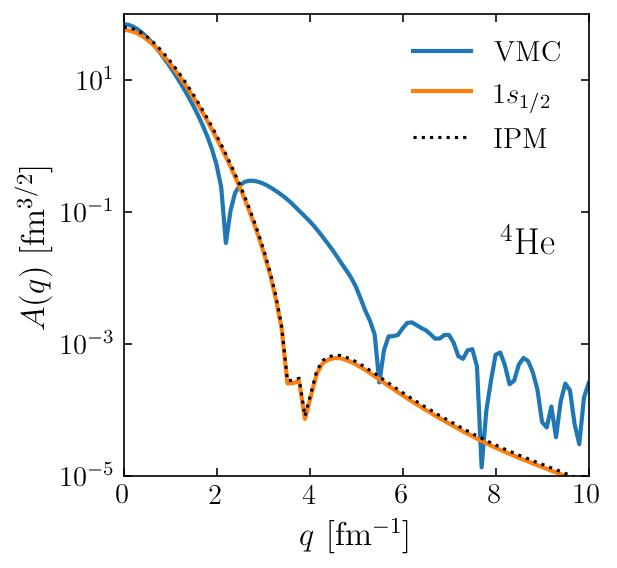

In [27]:
plot_spectroscopic_amplitude(
    q_array, q_weights, amplitude_array, n_alpha, l_alpha, j_alpha,
    ipm_array=ipm_amplitude_array, print_sf=True, show_vmc=True, save=True
)